In [ ]:
!pip install torch-lucent
!pip install torchsummary
!pip install ttach

In [1]:
import Model as md
import Resnet as res
import data as dta
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms as T
from torch.utils.data import DataLoader
from absl import app
from absl import flags
from absl import logging
import os
from tqdm import tqdm

from torch.cuda import amp
import pandas as pd
import math
from torchsummary import summary
import numpy as np
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
encoder = res.ResNet50().to(device)
proj_head = md.Projection_Head(encoder.representation_dim, 3).to(device)
#sup_head = md.Supervised_Head(encoder.representation_dim,5).to(device)#proj_head.output, 5).to(device)

In [4]:
transf_eval = T.Compose([
    T.CenterCrop(520), #395
    T.Resize(112), #112
    T.ToTensor(),
])

In [5]:
astro_ds = dta.AstroDataset('grad_cam0.csv', 'imagenes_clasificadas_nair/', transform=transf_eval)
dataset_astro = DataLoader(astro_ds,batch_size=64, shuffle=False,num_workers=6)

In [6]:
tensors = next(iter(dataset_astro))
tensors = tensors[0]
tensors.shape

torch.Size([50, 3, 112, 112])

In [12]:
checkpoint = torch.load('torch_exp1_only_pretrain/model.pt')#'finetuned_model_lr0.03_weights/model.pt')
encoder.load_state_dict(checkpoint['encoder'])
proj_head.load_state_dict(checkpoint['projection_head'], strict=True)
#sup_head.load_state_dict(checkpoint['supervised_head'])

<All keys matched successfully>

In [13]:
class AstroModel(nn.Module):
    def __init__(self, encoder, projection_head, supervised_head):
        super(AstroModel, self).__init__()
        self.encoder = encoder
        self.projection_head = projection_head
        #self.supervised_head = supervised_head
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.projection_head(x)
        #x = self.supervised_head(x)
        return x

In [14]:
model = AstroModel(encoder, proj_head, 'sup_head')

In [15]:
#model = model.eval()

In [16]:
from itertools import product
import sys
from PIL import Image

import numpy as np
import torch
import torchvision

from lucent.modelzoo import *
from lucent.misc.io import show
import lucent.optvis.objectives as objectives
import lucent.optvis.param as param
import lucent.optvis.render as render
import lucent.optvis.transform as transform
from lucent.misc.channel_reducer import ChannelReducer
from lucent.misc.io import show

In [17]:
from PIL import Image
import lucent.optvis.transform as transform

In [18]:
@torch.no_grad()
def get_layer(model, layer, X):
    hook = render.ModuleHook(getattr(model, layer))
    model(X)
    hook.close()
    return hook.features


@objectives.wrap_objective()
def dot_compare(layer, acts, batch=1):
    def inner(T):
        pred = T(layer)[batch]
        return -(pred * acts).sum(dim=0, keepdims=True).mean()

    return inner

In [19]:
def render_activation_grid_less_naive(
    img,
    model,
    layer="layer1",
    cell_image_size=32,
    n_groups=6,
    n_steps=1024,
    batch_size=64,
):
    # First wee need, to normalize and resize the image
    #img = torch.tensor(np.transpose(img, [2, 0, 1])).to(device)
    #normalize = (
    #    transform.preprocess_inceptionv1()
    #    if model._get_name() == "InceptionV1"
    #    else transform.normalize()
    #)
    #transforms = transform.standard_transforms.copy() + [
    #    normalize,
    #    torch.nn.Upsample(size=224, mode="bilinear", align_corners=True),
    #]
    #transforms_f = transform.compose(transforms)
    # shape: (1, 3, original height of img, original width of img)
    img = img.unsqueeze(0)
    # shape: (1, 3, 224, 224)
    #img = transforms_f(img)

    # Here we compute the activations of the layer `layer` using `img` as input
    # shape: (layer_channels, layer_height, layer_width), the shape depends on the layer
    acts = get_layer(model, layer, img)[0]
    # shape: (layer_height, layer_width, layer_channels)
    acts = acts.permute(1, 2, 0)
    # shape: (layer_height*layer_width, layer_channels)
    acts = acts.view(-1, acts.shape[-1])
    acts_np = acts.cpu().numpy()
    nb_cells = acts.shape[0]

    # negative matrix factorization `NMF` is used to reduce the number
    # of channels to n_groups. This will be used as the following.
    # Each cell image in the grid is decomposed into a sum of
    # (n_groups+1) images. First, each cell has its own set of parameters
    #  this is what is called `cells_params` (see below). At the same time, we have
    # a of group of images of size 'n_groups', which also have their own image parametrized
    # by `groups_params`. The resulting image for a given cell in the grid
    # is the sum of its own image (parametrized by `cells_params`)
    # plus a weighted sum of the images of the group. Each each image from the group
    # is weighted by `groups[cell_index, group_idx]`. Basically, this is a way of having
    # the possibility to make cells with similar activations have a similar image, because
    # cells with similar activations will have a similar weighting for the elements
    # of the group.
    if n_groups > 0:
        reducer = ChannelReducer(n_groups, "NMF")
        groups = reducer.fit_transform(acts_np)
        groups /= groups.max(0)
    else:
        groups = np.zeros([])
    # shape: (layer_height*layer_width, n_groups)
    groups = torch.from_numpy(groups)

    # Parametrization of the images of the groups (we have 'n_groups' groups)
    groups_params, groups_image_f = param.fft_image(
        [n_groups, 3, cell_image_size, cell_image_size]
    )
    # Parametrization of the images of each cell in the grid (we have 'layer_height*layer_width' cells)
    cells_params, cells_image_f = param.fft_image(
        [nb_cells, 3, cell_image_size, cell_image_size]
    )

    # First, we need to construct the images of the grid
    # from the parameterizations

    def image_f():
        groups_images = groups_image_f()
        cells_images = cells_image_f()
        X = []
        for i in range(nb_cells):
            x = 0.7 * cells_images[i] + 0.5 * sum(
                groups[i, j] * groups_images[j] for j in range(n_groups)
            )
            X.append(x)
        X = torch.stack(X)
        return X

    # make sure the images are between 0 and 1
    image_f = param.to_valid_rgb(image_f, decorrelate=True)

    # After constructing the cells images, we sample randomly a mini-batch of cells
    # from the grid. This is to prevent memory overflow, especially if the grid
    # is large.
    def sample(image_f, batch_size):
        def f():
            X = image_f()
            inds = torch.randint(0, len(X), size=(batch_size,))
            inputs = X[inds]
            # HACK to store indices of the mini-batch, because we need them
            # in objective func. Might be better ways to do that
            sample.inds = inds
            return inputs

        return f

    image_f_sampled = sample(image_f, batch_size=batch_size)

    # Now, we define the objective function

    def objective_func(model):
        # shape: (batch_size, layer_channels, cell_layer_height, cell_layer_width)
        pred = model(layer)
        # use the sampled indices from `sample` to get the corresponding targets
        target = acts[sample.inds].to(pred.device)
        # shape: (batch_size, layer_channels, 1, 1)
        target = target.view(target.shape[0], target.shape[1], 1, 1)
        dot = (pred * target).sum(dim=1).mean()
        return -dot

    obj = objectives.Objective(objective_func)

    def param_f():
        # We optimize the parametrizations of both the groups and the cells
        params = list(groups_params) + list(cells_params)
        return params, image_f_sampled

    results = render.render_vis(
        model,
        obj,
        param_f,
        thresholds=(n_steps,),
        show_image=False,
        progress=True,
        fixed_image_size=cell_image_size,
    )
    # shape: (layer_height*layer_width, 3, grid_image_size, grid_image_size)
    imgs = image_f()
    imgs = imgs.cpu().data
    imgs = imgs[:, :, 2:-2, 2:-2]
    # turn imgs into a a grid
    grid = torchvision.utils.make_grid(imgs, nrow=int(np.sqrt(nb_cells)), padding=0)
    grid = grid.permute(1, 2, 0)
    grid = grid.numpy()
    render.show(grid)
    return imgs

/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
100%|██████████| 1024/1024 [00:44<00:00, 22.94it/s]



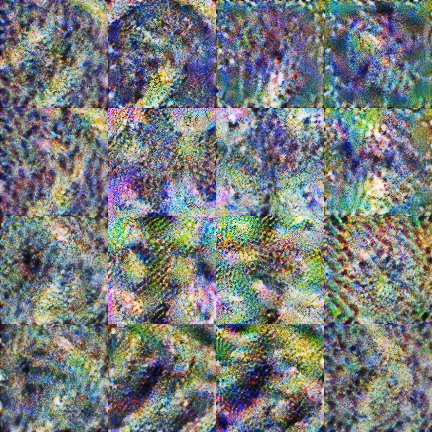

In [69]:
_ = render_activation_grid_less_naive(
    tensors[5].to(device), model.encoder, cell_image_size=112, n_steps=1024, batch_size=32, layer='layer4'
)

In [21]:
_.shape

torch.Size([784, 3, 108, 108])

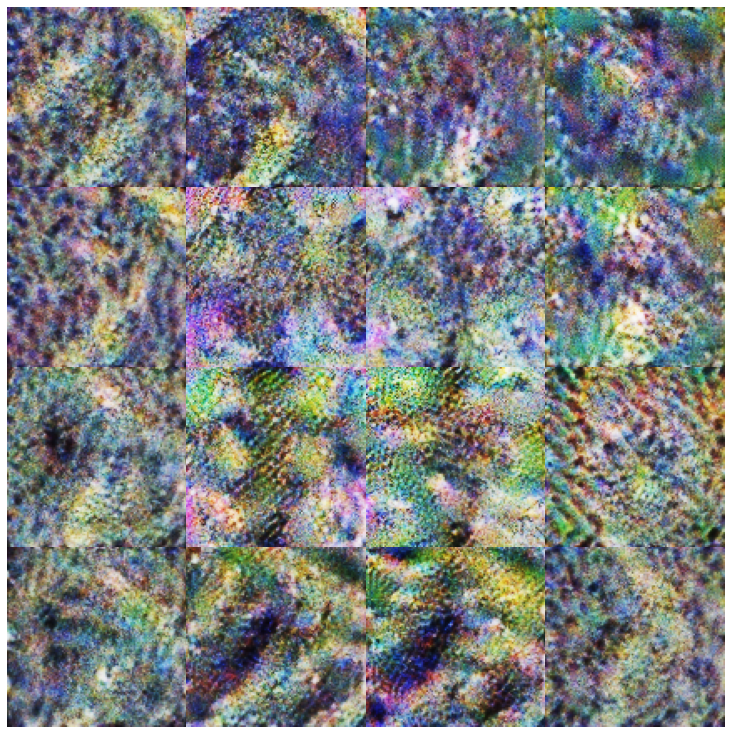

In [70]:
num = _.numpy()
num = np.transpose(num, (0,2,3,1))
w = 20
h = 20
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 4
for i in range(0, columns*rows):
    img = num[i]
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.imshow(img)
plt.tight_layout(pad=0)
plt.savefig('out.png', dpi=100)
plt.show()

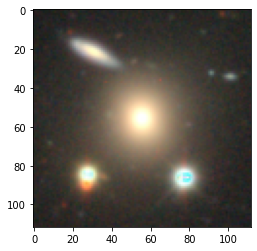

In [62]:
plt.imshow(tensors[5].permute(1, 2, 0));